In [494]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import numpy as np


In [495]:
def fill(start_date, end_date, previous_df, df):

    # Prepare data for training the model
    X_train = previous_df['pv_measurement'].values.reshape(-1, 1)
    y_train = previous_df['pv_measurement'].values

    # Initialize and train the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)


    # Find the corresponding time range in the previous dataset
    previous_missing_data_df = previous_df[(previous_df['time'] >= start_date) & (previous_df['time'] <= end_date)]

    # Prepare the data that we have for prediction
    X_missing = previous_missing_data_df['pv_measurement'].values.reshape(-1, 1)

    # Impute the missing data using the trained model
    y_missing_imputed = model.predict(X_missing)

    # Prepare the new time range to fill in the current dataset
    missing_time_range = pd.date_range(start=start_date, end=end_date, freq='H')[:-1]  # Exclude the last point to match the number of hours
    len_y_missing_imputed = len(y_missing_imputed)
    len_missing_time_range = len(missing_time_range)

    len_y_missing_imputed, len_missing_time_range
    # Create a DataFrame for the imputed data
    adjusted_missing_time_range = missing_time_range[:len_y_missing_imputed]

    y_missing_imputed = y_missing_imputed[:len(missing_time_range)]


    # Create a DataFrame for the imputed data
    imputed_df = pd.DataFrame({
        'time': adjusted_missing_time_range,
        'pv_measurement': y_missing_imputed
    })

    # Append the imputed data to the current dataset and sort by time
    df = pd.concat([df, imputed_df], ignore_index=True).sort_values(by='time').reset_index(drop=True)

        # Find the peak value in the previous dataset
    peak_previous = previous_df['pv_measurement'].max()

    # Find the peak value in the current dataset (excluding the imputed range)
    peak_current = df[df['time'] < start_date]['pv_measurement'].max()

    # Calculate the scaling factor
    scaling_factor = peak_current / (peak_previous)

    # Scale down the imputed values using the scaling factor
    df.loc[(df['time'] >= start_date) & (df['time'] <= end_date), 'pv_measurement'] *= scaling_factor

    plt.figure(figsize=(18, 6))
    plt.plot(df['time'], df['pv_measurement'], marker='o', markersize=2, linestyle='-')
    plt.title('PV Measurement with Scaled Imputed Values')
    plt.xlabel('Time')
    plt.ylabel('PV Measurement')
    plt.show()

    return df

In [496]:
df = pd.read_parquet('/Users/petterdalhaug/Documents/GitHub/data_analysis/analysis/data/B/train_targets.parquet')

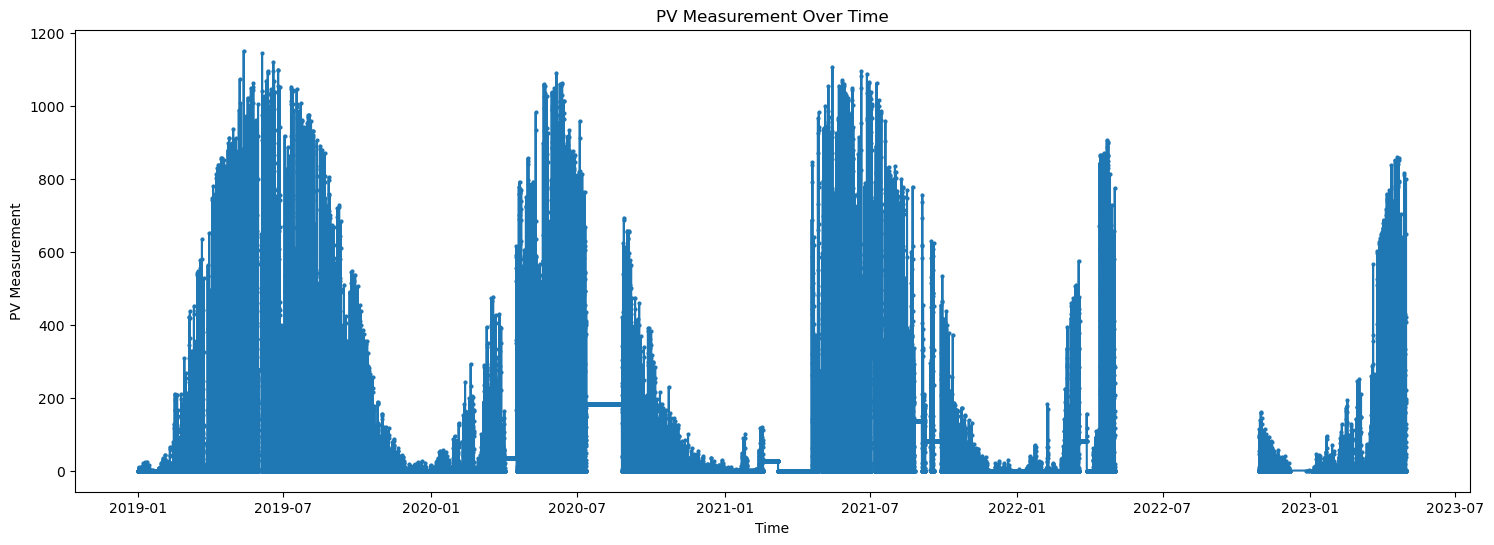

In [497]:

# Convert the time column to datetime format for better plotting
df['time'] = pd.to_datetime(df['time'])

# Plotting the data
plt.figure(figsize=(18, 6))
plt.plot(df['time'], df['pv_measurement'], marker='o', markersize=2, linestyle='-')
plt.title('PV Measurement Over Time')
plt.xlabel('Time')
plt.ylabel('PV Measurement')
plt.show()

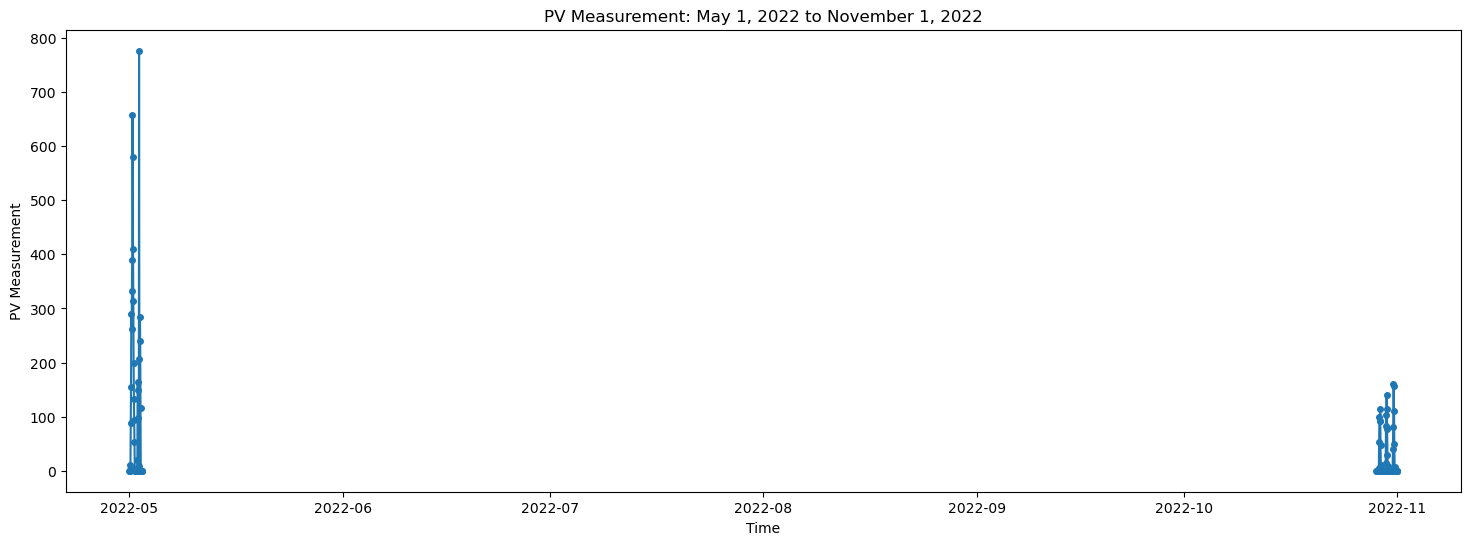

In [498]:
start_date = '2022-05-01'
end_date = '2022-11-01'
filtered_df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]

# Plotting the filtered data
plt.figure(figsize=(18, 6))
plt.plot(filtered_df['time'], filtered_df['pv_measurement'], marker='o', markersize=4, linestyle='-')
plt.title('PV Measurement: May 1, 2022 to November 1, 2022')
plt.xlabel('Time')
plt.ylabel('PV Measurement')
plt.show()

In [499]:
previous_df = pd.read_parquet('/Users/petterdalhaug/Documents/GitHub/data_analysis/analysis/data/A/train_targets.parquet')
previous_df['time'] = pd.to_datetime(previous_df['time'])



In [500]:

# Merge the two datasets on the "time" column to find overlapping time periods
merged_df = pd.merge(df, previous_df, on='time', how='inner', suffixes=('_current', '_previous'))

# Drop rows where any of the measurements are NaN
clean_merged_df = merged_df.dropna(subset=['pv_measurement_current', 'pv_measurement_previous'])

# Recalculate the Pearson correlation coefficient
correlation_coefficient_clean, _ = pearsonr(clean_merged_df['pv_measurement_current'], clean_merged_df['pv_measurement_previous'])

correlation_coefficient_clean


0.8547041108685307

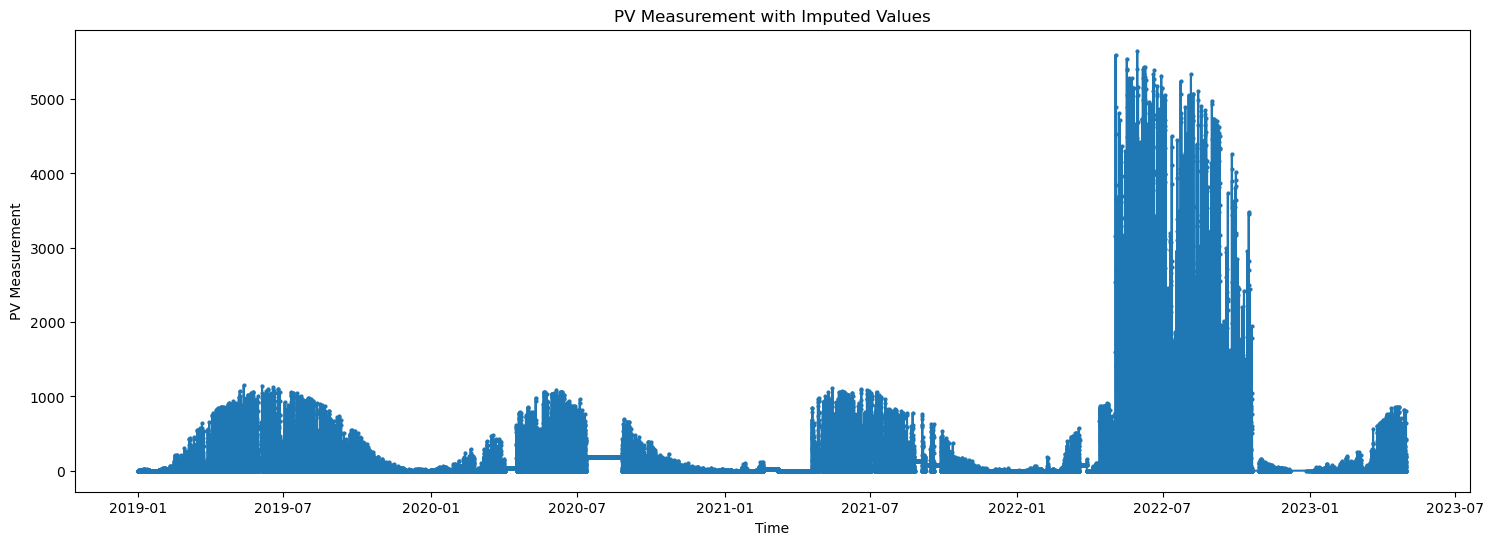

In [501]:
# Prepare data for training the model
X_train = previous_df['pv_measurement'].values.reshape(-1, 1)
y_train = previous_df['pv_measurement'].values

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Filter the current dataset to get the missing range
missing_data_df = df[(df['time'] >= '2022-05-03') & (df['time'] <= '2022-10-28')]

# Find the corresponding time range in the previous dataset
previous_missing_data_df = previous_df[(previous_df['time'] >= '2022-05-03') & (previous_df['time'] <= '2022-10-28')]

# Prepare the data that we have for prediction
X_missing = previous_missing_data_df['pv_measurement'].values.reshape(-1, 1)

# Impute the missing data using the trained model
y_missing_imputed = model.predict(X_missing)

# Prepare the new time range to fill in the current dataset
missing_time_range = pd.date_range(start='2022-05-03', end='2022-10-28', freq='H')[:-1]  # Exclude the last point to match the number of hours
len_y_missing_imputed = len(y_missing_imputed)
len_missing_time_range = len(missing_time_range)

len_y_missing_imputed, len_missing_time_range
# Create a DataFrame for the imputed data
adjusted_missing_time_range = missing_time_range[:len_y_missing_imputed]

# Create a DataFrame for the imputed data
imputed_df = pd.DataFrame({
    'time': adjusted_missing_time_range,
    'pv_measurement': y_missing_imputed
})

# Append the imputed data to the current dataset and sort by time
df = pd.concat([df, imputed_df], ignore_index=True).sort_values(by='time').reset_index(drop=True)

# Validate by plotting the imputed range
plt.figure(figsize=(18, 6))
plt.plot(df['time'], df['pv_measurement'], marker='o', markersize=2, linestyle='-')
plt.title('PV Measurement with Imputed Values')
plt.xlabel('Time')
plt.ylabel('PV Measurement')
plt.show()


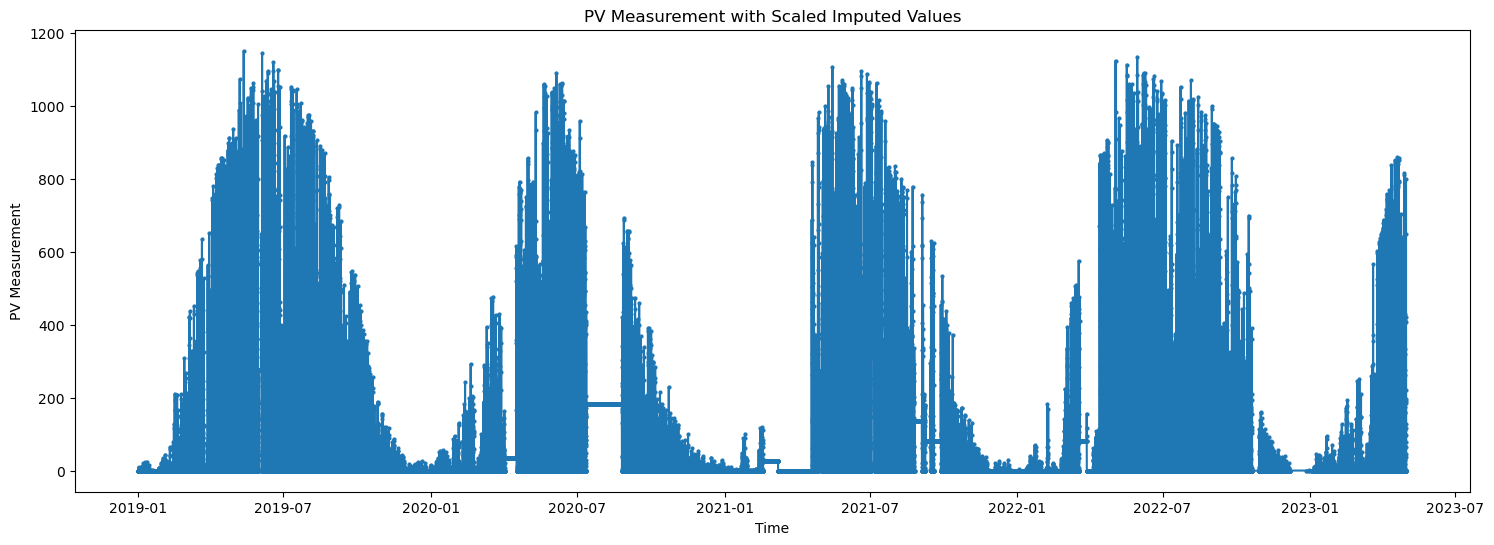

0.20097952007702208

In [502]:
# Find the peak value in the previous dataset
peak_previous = previous_df['pv_measurement'].max()

# Find the peak value in the current dataset (excluding the imputed range)
peak_current = df[df['time'] < '2022-05-03']['pv_measurement'].max()

# Calculate the scaling factor
scaling_factor = peak_current / peak_previous

# Scale down the imputed values using the scaling factor
df.loc[(df['time'] >= '2022-05-03') & (df['time'] <= '2022-10-28'), 'pv_measurement'] *= scaling_factor

# Validate by plotting the scaled imputed range
plt.figure(figsize=(18, 6))
plt.plot(df['time'], df['pv_measurement'], marker='o', markersize=2, linestyle='-')
plt.title('PV Measurement with Scaled Imputed Values')
plt.xlabel('Time')
plt.ylabel('PV Measurement')
plt.show()

scaling_factor

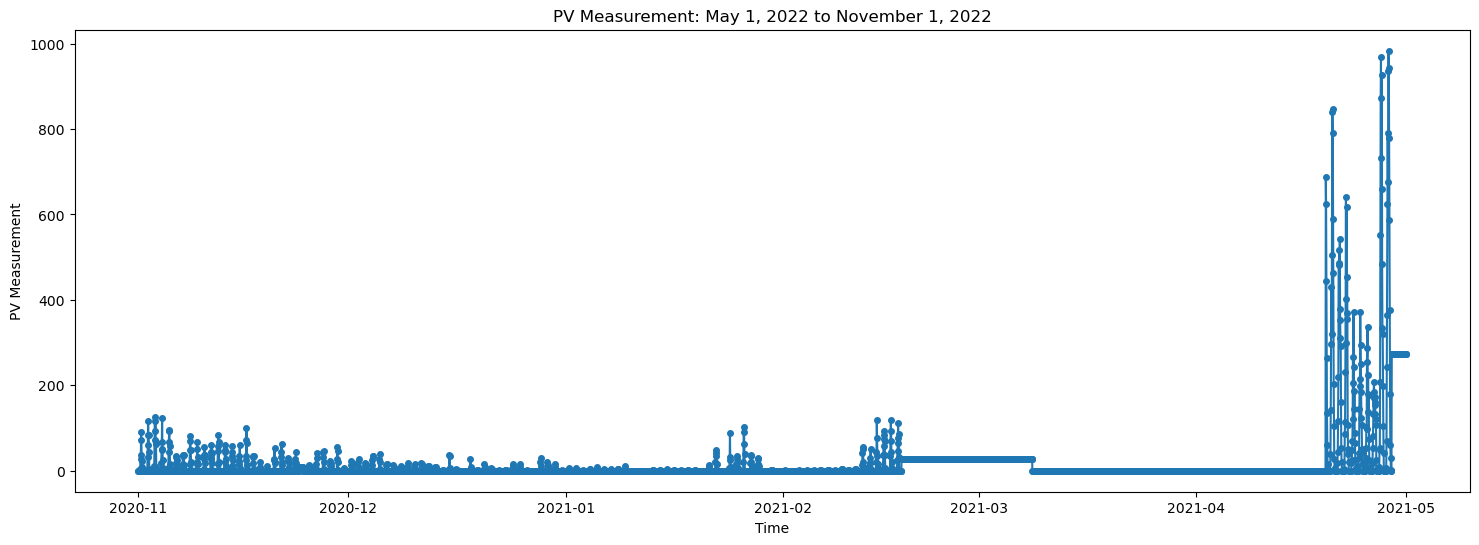

In [503]:
# Filter data around the suspected gap range
start_date = '2020-11-01'
end_date = '2021-05-01'
filtered_df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]

# Plotting the filtered data
plt.figure(figsize=(18, 6))
plt.plot(filtered_df['time'], filtered_df['pv_measurement'], marker='o', markersize=4, linestyle='-')
plt.title('PV Measurement: May 1, 2022 to November 1, 2022')
plt.xlabel('Time')
plt.ylabel('PV Measurement')
plt.show()

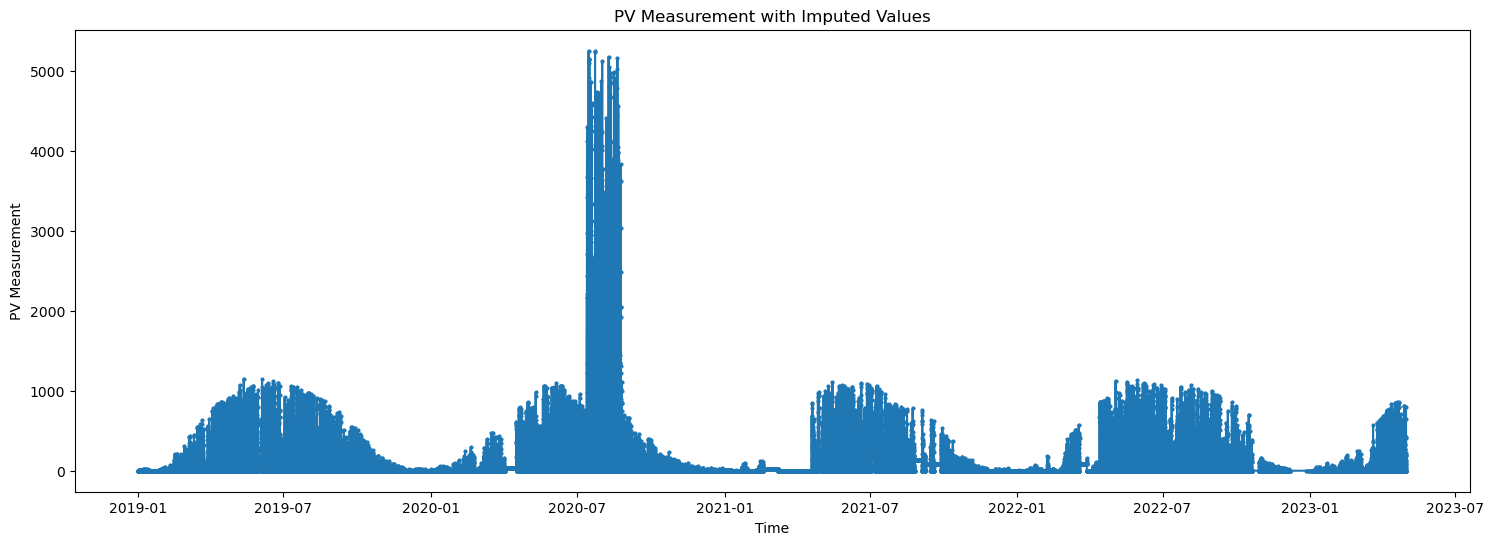

In [504]:
# Prepare data for training the model
X_train = previous_df['pv_measurement'].values.reshape(-1, 1)
y_train = previous_df['pv_measurement'].values

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Filter the current dataset to get the missing range
missing_data_df = df[(df['time'] >= '2020-07-13') & (df['time'] <= '2020-08-26')]

# Find the corresponding time range in the previous dataset
previous_missing_data_df = previous_df[(previous_df['time'] >= '2020-07-13') & (previous_df['time'] <= '2020-08-26')]

# Prepare the data that we have for prediction
X_missing = previous_missing_data_df['pv_measurement'].values.reshape(-1, 1)

# Impute the missing data using the trained model
y_missing_imputed = model.predict(X_missing)

# Prepare the new time range to fill in the current dataset
missing_time_range = pd.date_range(start='2020-07-13', end='2020-08-26', freq='H')[:-1]  # Exclude the last point to match the number of hours
len_y_missing_imputed = len(y_missing_imputed)
len_missing_time_range = len(missing_time_range)

len_y_missing_imputed, len_missing_time_range
# Create a DataFrame for the imputed data
adjusted_missing_time_range = missing_time_range[:len_y_missing_imputed]

y_missing_imputed = y_missing_imputed[:len(missing_time_range)]


# Create a DataFrame for the imputed data
imputed_df = pd.DataFrame({
    'time': adjusted_missing_time_range,
    'pv_measurement': y_missing_imputed
})

# Append the imputed data to the current dataset and sort by time
df = pd.concat([df, imputed_df], ignore_index=True).sort_values(by='time').reset_index(drop=True)

# Validate by plotting the imputed range
plt.figure(figsize=(18, 6))
plt.plot(df['time'], df['pv_measurement'], marker='o', markersize=2, linestyle='-')
plt.title('PV Measurement with Imputed Values')
plt.xlabel('Time')
plt.ylabel('PV Measurement')
plt.show()

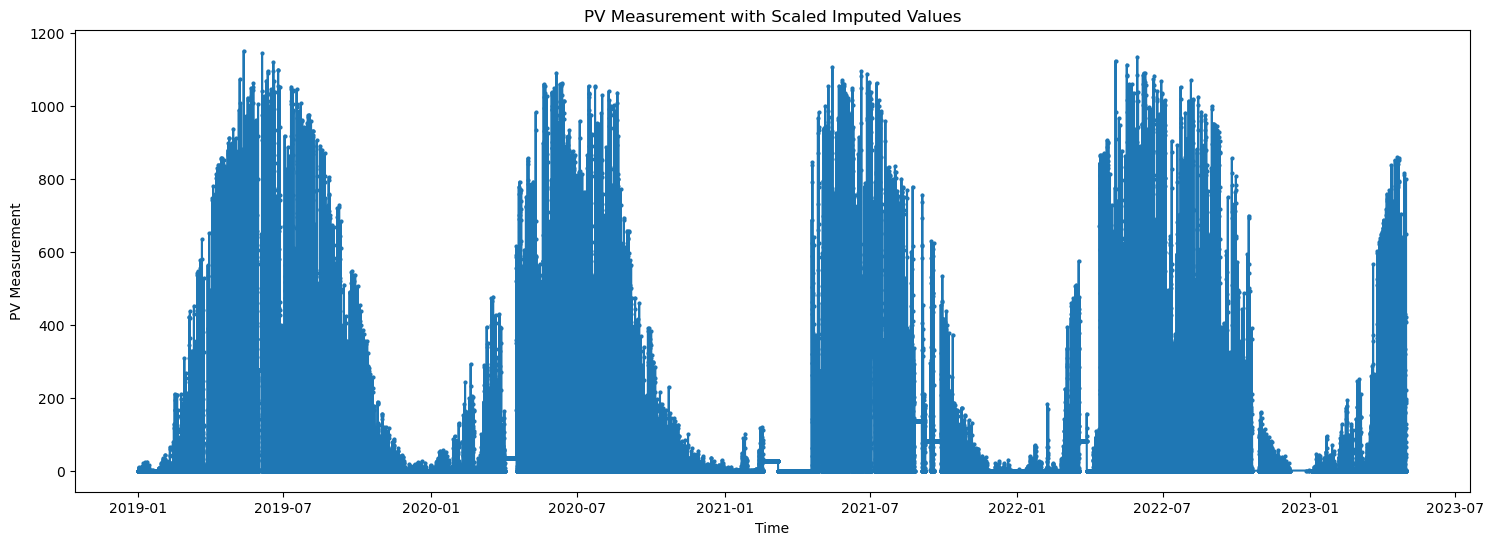

0.20097952007702208

In [505]:
# Find the peak value in the previous dataset
peak_previous = previous_df['pv_measurement'].max()

# Find the peak value in the current dataset (excluding the imputed range)
peak_current = df[df['time'] < '2020-07-13']['pv_measurement'].max()

# Calculate the scaling factor
scaling_factor = peak_current / (peak_previous)

# Scale down the imputed values using the scaling factor
df.loc[(df['time'] >= '2020-07-13') & (df['time'] <= '2020-08-26'), 'pv_measurement'] *= scaling_factor

# Validate by plotting the scaled imputed range
plt.figure(figsize=(18, 6))
plt.plot(df['time'], df['pv_measurement'], marker='o', markersize=2, linestyle='-')
plt.title('PV Measurement with Scaled Imputed Values')
plt.xlabel('Time')
plt.ylabel('PV Measurement')
plt.show()

scaling_factor

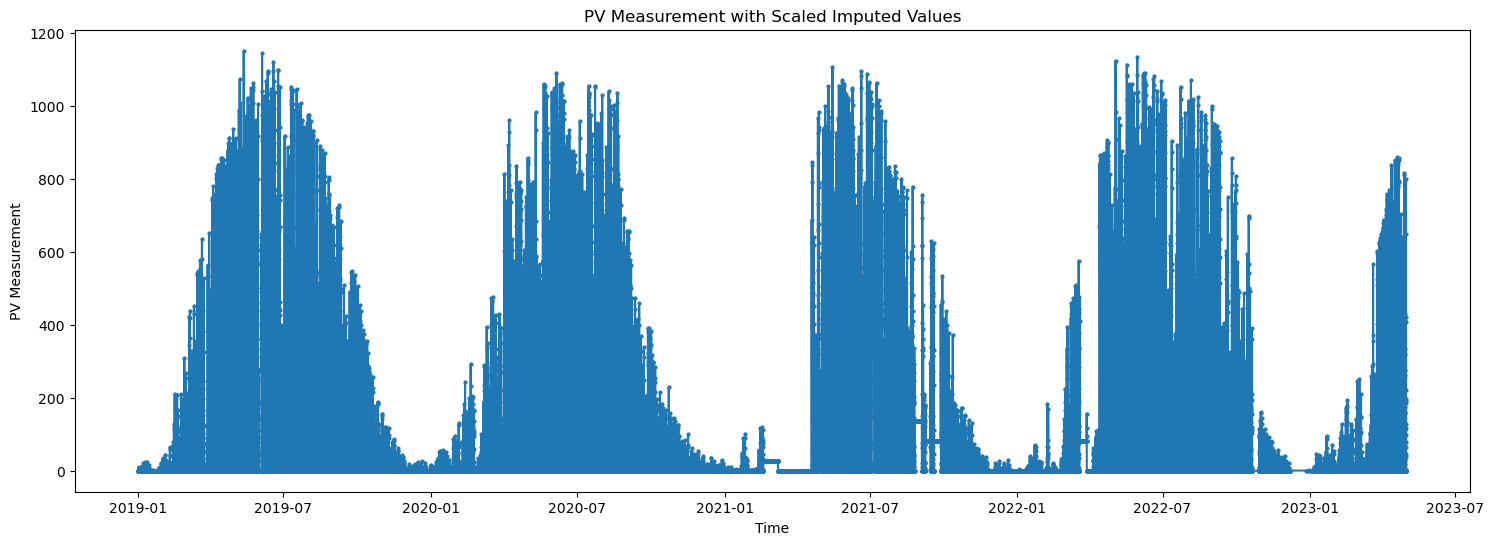

In [506]:
start_date = '2020-04-01'
end_date = '2020-04-17'

df = fill(start_date, end_date, previous_df, df)

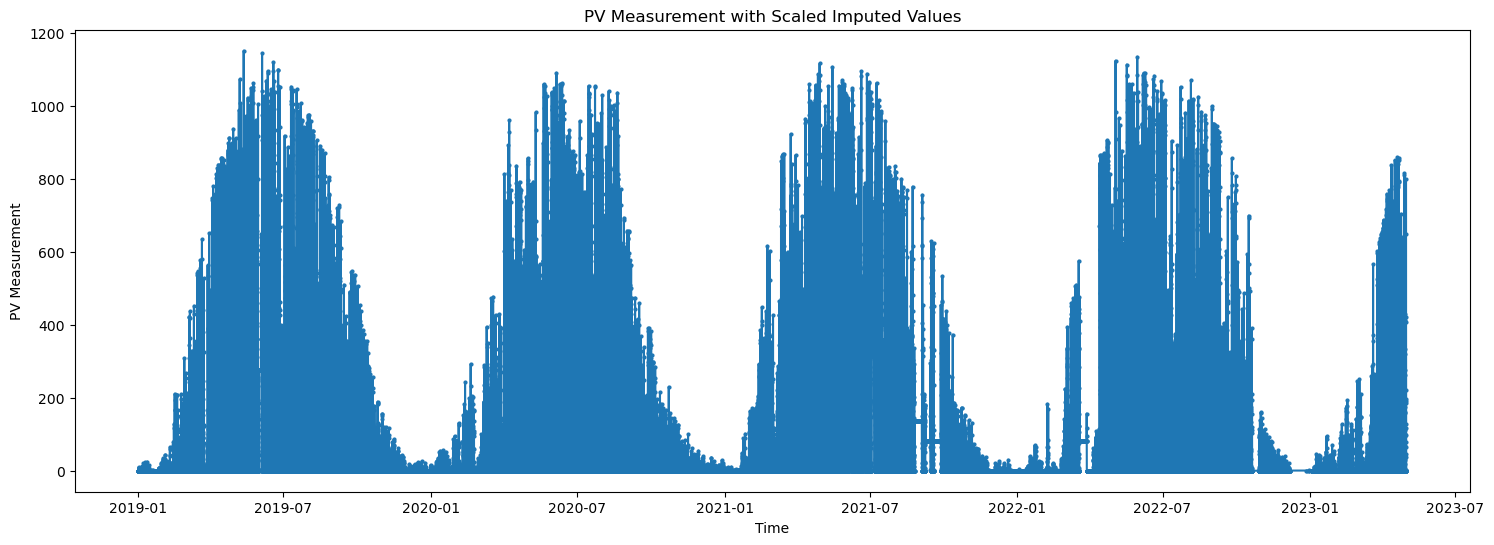

In [507]:
start_date = '2021-01-30'
end_date = '2021-05-01'
df = fill(start_date, end_date, previous_df, df)